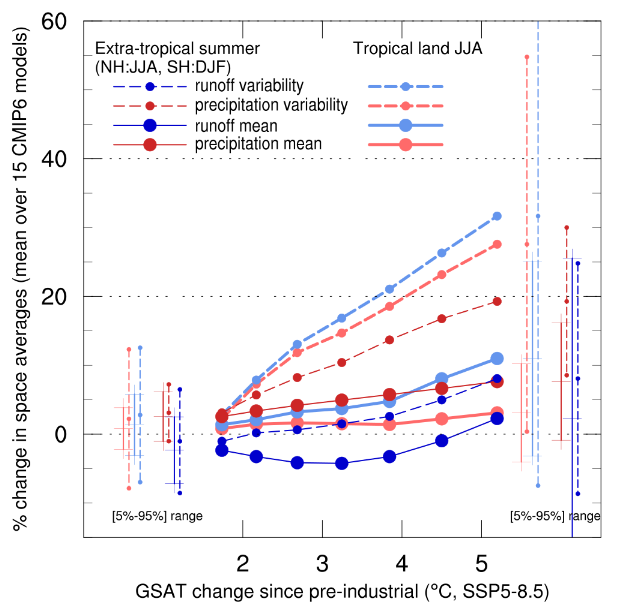

In [ ]:
version               = ""
input_dir             = "./changes"
outdir                = "./figures"
figure_name           = "fig_SOD_BoxTS.X_f3_h"
panel                 = "h"
title                 = ""
yaxis_title           = "%% change in space averages "

#
data_versions_tag     = "20200719d"
excluded_models       = []
scenario              = "ssp585"
variables             = [("pr","mean"),("mrro","mean"), ("pr","std"), ("mrro","std")]
option                = "mean"
combined_seasons      = [ "tropics_JJA", "extra_summer" ]

#
colors                = {"tropics_JJA"     : {"pr":"indianred1","mrro":"cornflowerblue"},
                         "extra_summer"    : {"pr":"firebrick3","mrro":"blue3"},
                         "land_annual"     : { "pr":"firebrick3","mrro":"blue3","prw":"green"},
                         "tropics_annual"  : { "pr":"firebrick3","mrro":"blue3","prw":"green"}}
thicknesses           = {"tropics_JJA" :10.0,"extra_summer" : 4.0 , "land_annual":10.0, "tropics_annual":10.0}
xyMarkLineModes       = {"mean":"MarkLines","std":"MarkLines"}
xyDashPatterns        = {"mean":0,"std":1 }
xyMarkerSizes         = {"pr_mean" : 0.015,"mrro_mean" : 0.015,"pr_std" : 0.01,"mrro_std": 0.01, "prw_mean": 0.01}
nice                  = {"pr":"precipitation","prw":"precipitable water ","mrro":"runoff",
                        "tropics_JJA":"Tropical land JJA",
                        "extra_summer" : "Extra-tropical summer ~C~(NH:JJA, SH:DJF)",
                        "land_annual" : "Land annual", "tropics_annual" : "Tropics annual", 
                        "mean":"mean", "std" : "inter-annual variability",
                        }
only_warmer_CI        = False # Should we show Confidence Interval bars only at warm end
show_variability_CI   = True  # Should we show Confidence Interval bars also for variability 
show_mean_CI          = True  # Should we show Confidence Interval bars also for means 
xy_ranges             = (0.,6.5,-15.,60.)
#

In [ ]:
if False :
    input_dir="/data/ssenesi/prod/fig_SOD_8.16/changes"
    combined_seasons      = [ "extra_summer"  ]

In [ ]:
#option                = "median"
#input_dir             = "/home/ssenesi/CAMMAC/notebookœa/prod/fig_SOD_8.16/changes"


In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
import numpy as np
import Ngl
import os
import json
from IPython.display import Image

In [ ]:
def ensemble_stat_series(stats,variable,stat,season,option) :
    """ Compute mean or quantile on an ensemble """
    #
    global excluded_models
    
    series=stats[variable][stat][season]["ens"]
    periods=series.keys()
    periods.sort()
    ret=[]
    for p in periods :
        ens_dic=series[p]
        ens = [ens_dic[m] for m in ens_dic if m not in excluded_models ]
        if option == "mean":
            ret.append(np.mean(ens))
        elif option == "median":
            ret.append(np.median(ens))
        #
        elif option in ["min","max"] :
            l=[ value for value in ens ]
            l.sort()
            if option=="min"     : ret.append(np.float64(l[0]))
            if option=="max"     : ret.append(np.float64(l[-1]))
        #
        elif option in ["nq5","nq95" ] : #percentiles with gaussian hypothesis
            mean=np.mean(ens)
            std1=np.std(ens.values(),ddof=1)
            if option == "nq5"   : ret.append(mean - 1.645*std1)
            if option == "nq95"  : ret.append(mean + 1.645*std1)
        #
        else:
            raise ValueError("Time to use some library for stats (%s) !"%option)
    return(ret)

In [ ]:
def season_plot(wks,all_stats,season,ssp,variables,option,errors,only_warmer=only_warmer_CI,
                show_variability_CI=show_variability_CI,
                show_mean_CI=show_mean_CI,
                rank=1,key="",xy_ranges=(0.,6.5,-15.,60.),title=""):
    """
    rank : allows to decide for a shift of the legend
    key : text for the legend
    """
    #GTAS_shift=0.89 # Shift for GTAS between 1995-2014 and 1850-1900, based on AR6 WL Box table
    #GTAS_shift=0.   # No shift if GTAS computed for 1850-1900
    if ssp not in all_stats :
        raise ValueError("SSP %s is not documented in input dictionnary"%ssp)
    stats=all_stats[ssp]
    #
    # Gathering time series of ensemble mean of time statistics for required variables
    means=[]  # their mean value
    for variable,stat in variables :
        #d=stats[variable][stat][season][option]
        #periods=sorted(d) 
        #means.append([ d[p] for p in periods ])
        means.append(ensemble_stat_series(stats,variable,stat,season,option))
    #
    if len(means)==0 : 
        raise ValueError("No matching variable in stats "+repr(stats.keys()))
    if len(means)>0 :
        y=np.array(means,np.float32)
        periods  = stats["tas"]["mean"]["globe_year"]["mean"].keys()
        periods.sort()
        GTAS  = [ stats["tas"]["mean"]["globe_year"]["mean"][p] for p in periods ]
        models_nb=len(stats["tas"]["models"])

        #-- set resources
        res                  =  Ngl.Resources()       #-- generate an res object for plot
        res.nglDraw    = False                        # don't draw
        res.nglFrame   = False                        # don't advance frame
        res.gsnMaximize = False
        res.gsnPaperOrientation="landscape"
        res.tiMainString = title
        res.tiMainFontHeightF = 0.02
        #
        res.trXMinF,res.trXMaxF,res.trYMinF,res.trYMaxF = xy_ranges
        #
        res.tmYMajorGrid  = True
        dpat = Ngl.new_dash_pattern(wks,"_____$_____$_____$_____$_____$_____$_____$_____$_____$_____")
        res.tmYMajorGridLineDashPattern =  dpat #15
        
        #res.tmYLMode = "Explicit"
        res.tmYLValues = [-10.,0.,10.,20.,30.,40.,50.]
        #res.tmYLMode = "Automatic"
        res.tmYLMode = "Manual"
        res.tmYLTickStartF  = -20.
        res.tmYLDataBottomF = -20.
        res.tmYLDataTopF    =  40.
        res.tmYLTickSpacingF=  20
        #
        res.tmXBMode = "Explicit"
        res.tmXBValues = [ 2,3,4,5]
        res.tmXBLabels = [ "2","3","4","5"] 
        res.tmXBTickStartF  =   0.
        res.tmXBTickSpacingF=   1.
        

        res.tmXBDataLeftF   =  1.4
        res.tmXBDataRightF  =  5.4
        #
        res.tiYAxisString    = yaxis_title + " (mean over %d CMIP6 models)"%models_nb
        res.tiYAxisFontHeightF = 0.016
        res.tiXAxisString    = "GSAT change since pre-industrial (~F34~0~F~C, SSP5-8.5)"   #-- x-axis title
        res.tiXAxisFontHeightF = 0.016
        
        #-- xy-plot resources
        res.xyLineColors     = [colors[season][v] for v,s in variables] #-- set 3 different colors for lines
        res.xyLineThicknessF = [thicknesses[season]]               #-- line thickness for all
        res.xyDashPatterns   = [ xyDashPatterns [s] for v,s in variables]
        #
        res.xyMarkLineModes  = [ xyMarkLineModes[s] for v,s in variables]
        res.xyMarker         = 16
        res.xyMarkerSizes    = [ xyMarkerSizes.get("%s_%s"%(v,s),0.01) for v,s in variables]
        res.xyMarkerColors   = [colors[season][v] for v,s in variables] 

        #-- legend resources
        res.lgAutoManage     = False
        res.lgLabelJust      = "CenterLeft"
        res.lgBoxBackground  = 0
        res.pmLegendDisplayMode = "Always" 
        res.lgLabelFontAspectF = 1.5
        #res.lgLabelConstantSpacingF =0.0
        if rank == 1 :
            res.xyExplicitLegendLabels = ["  "+ nice[v]+" "+nice[s] for v,s in variables ]  #-- set explicit legend labels
            res.pmLegendParallelPosF =  -0.45     
        else :
            res.xyExplicitLegendLabels = [ "" for v,s in variables ]  #-- no legend labels
            res.pmLegendParallelPosF =  0.15       
        #
        res.pmLegendOrthogonalPosF =  0.4         #-- move the legend upwards
        res.pmLegendZone     =  0                     #-- legend zone: 0 = topLeft; 6 = topRight
        #res.pmLegendOrthogonalPosF =  0.5           #-- move the legend upwards
        res.lgJustification  = "TopLeft"          #-- legend justification
        res.pmLegendWidthF   =  0.15                  #-- change width
        res.pmLegendHeightF  =  0.1
        res.lgLabelFontHeightF = 0.015
        res.pmLegendSide     = "Top"                  #-- Change location
        res.lgPerimOn        =  False                 #-- turn off the perimeter
        #
        #res.xyLabelMode = "Custom"
        #res.xyLineLabelFontColors = res.xyLineColors
        #res.xyLineLabelFont  = "times-roman"
        #res.xyLineLabelFontQuality ="High"
        res.xyLineLabelFontColors = [colors[season][v] for v,s in variables]
        if key is None :
            res.pmLegendOrthogonalPosF =  0.47 #1.6         #-- move the legend upwards
        #-- creates the plot
        plot=Ngl.xy(wks,GTAS,y,res)
        
        #
        # Key label
        #
        if key is not None :
            rest=  Ngl.Resources() 
            rest.txFontHeightF = 0.02
            rest.txJust ="TopCenter"
            rest.txFuncCode ="~"
            if rank==1:
                xt=1.2
            elif rank== 2 :
                xt=5.2
            Ngl.add_text(wks, plot, key, xt, res.trYMaxF - 3., rest)
        #
        # Handling error bars
        #
        def dic2list(stat):
            dic=stats[v][s][season][stat]
            periods=dic.keys()
            periods.sort()
            l=[ dic[p] for p in periods ]
            return np.array(l,np.float32)
        index=-1
        CI_vars=variables
        if show_mean_CI is False :
            CI_vars=[ (var,stat) for (var,stat) in CI_vars if stat != "mean" ]
        if show_variability_CI is False :
            CI_vars=[ (var,stat) for (var,stat) in CI_vars if stat != "std" ]
            # CI_vars=[ (var,stat) for (var,stat) in CI_vars if ( var != "prw" or stat != "std" ) ]
        for v,s in CI_vars :
            index+=1
            if errors in ["second","butlast"] :
                ups =dic2list("butlast")
                lows =dic2list("second")
            elif errors in ["nq5", "nq95"] :
                ups =dic2list("nq95")
                lows =dic2list("nq5")
            elif errors in ["max", "min"] :
                ups =dic2list("max")
                lows =dic2list("min")
            elif errors == "means"  and "wmean" in stats[v][season] :
                ups =dic2list("wmean")
                lows =dic2list("iwmean")
            else : raise ValueError("errors option '%s' not (yet?) available"%errors)
            centers=dic2list("mean")
            polyres                   =  Ngl.Resources()
            if s=="std" :
                polyres.gsMarkerIndex     = 1        
            else :
                #polyres.gsMarkerIndex     = 2        
                polyres.gsMarkerIndex     = 1        
            polyres.gsMarkerSizeF     = .03     
            polyres.gsMarkerColor     = colors[season][v]
            polyres.gsLineColor       = colors[season][v]
            polyres.gsLineThicknessF  = 4. #2.
            polyres.gsLineDashPattern = xyDashPatterns[s]
            #polyres.gsLineDashPattern = xyDashPatterns["mean"]
            #
            # x-wise shift, dependent on variable
            if v=="pr" : 
                if s != "std":
                    delta=0.
                else :
                    delta=0.07
            elif v=="mrro"  :
                if s!="std"  :
                    delta=0.14
                else :
                    delta=0.21
            else : delta=0.
            #
            all_error_bars=zip(GTAS,centers,ups,lows)
            extremes=[ all_error_bars[0],all_error_bars[-1]]
            first=True
            if only_warmer :
                extremes=[ all_error_bars[-1]]
                first=False
            for t,center,up,low in extremes :
                if first : t0=xy_ranges[0]+0.5
                else : t0=xy_ranges[1]-1.
                if rank==1 : t0=t0+0.5
                Ngl.add_polymarker(wks,plot,t0+delta,up,polyres)
                Ngl.add_polymarker(wks,plot,t0+delta,center,polyres)
                Ngl.add_polymarker(wks,plot,t0+delta,low,polyres)
                Ngl.add_polyline  (wks,plot,[t0+delta,t0+delta],[up,low],polyres)
                first=False
                #
                if index==0 and rank==1 : #and season  in [ "extra_summer", "land_annual" ]:
                    rest=  Ngl.Resources() 
                    rest.txFontHeightF = 0.015
                    rest.txJust ="Center"
                    Ngl.add_text(wks, plot, "[5%-95%] range" , t0-0.41, res.trYMinF+5., rest)
        return plot

In [ ]:
def combined_figure(stats,outname,scenario,variables,option,errors):
    #
    wks_type        = "png"                       #-- output type of workstation
    wks             =  Ngl.open_wks(wks_type,outname)
    #
    # If actually combining seasons, the key must show each season name 
    # otherwise, we assume that the title includes it 
    if len(combined_seasons)==1 : 
        key=None
    else :
        key=nice[combined_seasons[0]]
    plot1=season_plot(wks,all_stats,combined_seasons[0],scenario, variables,option,
                      errors,only_warmer_CI,show_variability_CI,rank=1,key=key,
                      xy_ranges=xy_ranges,title=title)
    if len(combined_seasons) == 2 : 
        key=nice[combined_seasons[1]]
        plot2=season_plot(wks,all_stats,combined_seasons[1],scenario, variables,option,
                          errors,only_warmer_CI,show_variability_CI,rank=2, key=key,
                          xy_ranges=xy_ranges)
        Ngl.overlay(plot1,plot2)
    Ngl.draw(plot1)
    #
    Ngl.frame(wks)         # flush graphics to the wks
    Ngl.delete_wks(wks)    #-- this need to be done to cope with opened wks max number
    return outname+"."+wks_type


In [ ]:
with open ("%s/stats_CMIP6_%s%s.json"%(input_dir,data_versions_tag,version),"r") as f :
    all_stats=json.load(f)
ref_period=all_stats["ref_period"]

In [ ]:
filen="%s/%s_%s_%s_%s%s"%(outdir,figure_name,scenario,option,data_versions_tag,version)
! mkdir -p {outdir}
figfile=combined_figure(all_stats,filen,scenario,variables,option, errors="nq95")
print "Image available as %s"%figfile
Image(figfile)

In [ ]:
all_metadata=""
for variable,stat in variables + [("tas","mean")] :
    metadata=all_stats[scenario][variable]["models"]
    for model in metadata :
        if model not in excluded_models :
            string = metadata[model]
            string.replace("\n"," %s\n"%panel)
            all_metadata += string
with open("%s_md"%(filen),"w") as f: f.write(all_metadata)